# KnowledgeBase - Financial Data Time Series
LLM image analysis --> analyse_travel_destination --> Concierge


## a) PROMPT input

In [4]:
date = "2024-03-04"
prompt_0 = f"""
What is the current price of Bitcoin for today ({date})? What is the latest financial news, outlook on the crypto market, 
and also contrast with the traditional stock market and money market.
"""
from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

response = g_handler.prompt(prompt_0)
print(response.text)

**Current Price of Bitcoin (2024-03-04)**

As an AI language model, I do not have real-time access to the internet and cannot provide you with the current price of Bitcoin. For the most up-to-date information, please refer to a reputable cryptocurrency exchange or financial news source.

**Latest Financial News and Outlook on the Crypto Market**

I apologize, but I cannot access real-time news or provide specific market outlooks. For the latest financial news and market analysis, I recommend checking reliable news outlets and financial websites.

**Contrast with the Traditional Stock Market and Money Market**

**Stock Market:**

* **Asset Class:** Equities (stocks)
* **Price Drivers:** Company earnings, economic indicators, investor sentiment
* **Volatility:** Moderate to high, depending on market conditions
* **Returns:** Potential for significant gains, but also risk of losses
* **Regulation:** Highly regulated

**Money Market:**

* **Asset Class:** Short-term debt instruments (e.g.,

## b) Image input: Multimodal LLM image analysis

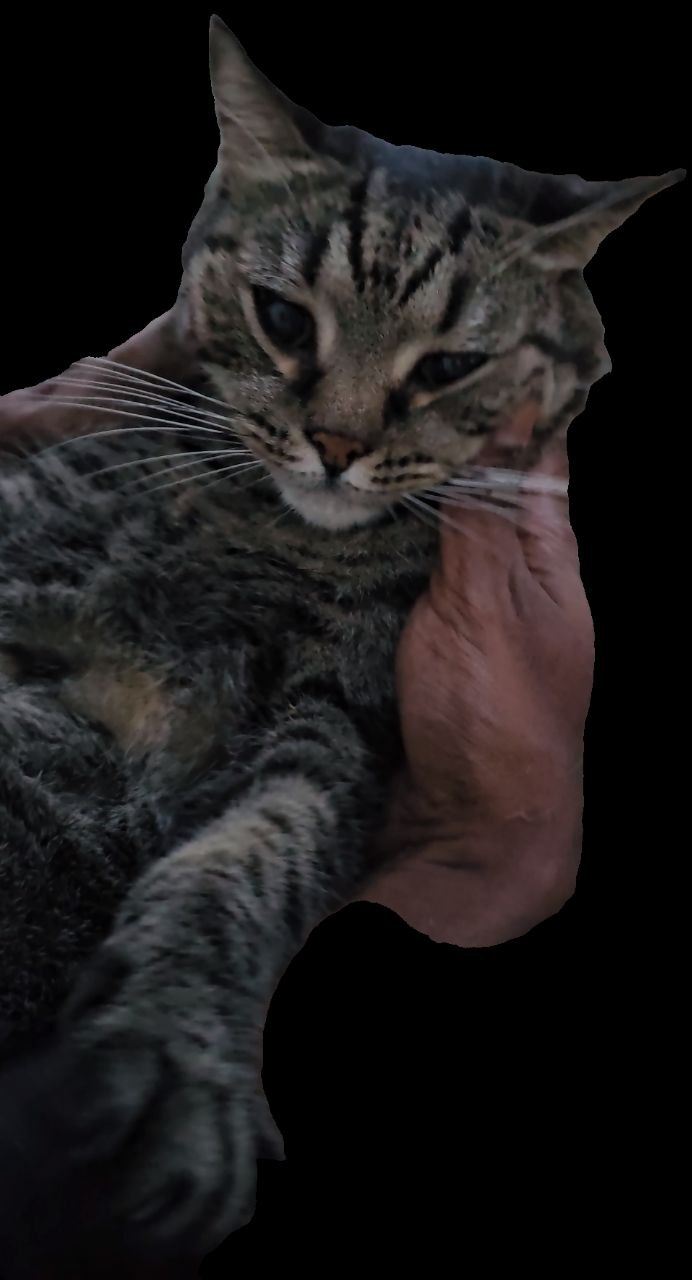

(' This image is not AI-generated. The lighting, the fur texture, and the pose '
 'of the cat all look very natural. There are no obvious signs of digital '
 'manipulation.\n'
 '\n'
 'The prompt that could result in a similar image would be: "A photo of a '
 'tabby cat being petted by a human hand."')


In [9]:
# image_path = "./database/quant/btcusdt_1d_IST.png"
image_path = "./database/quant/buddy_chinese.png"

prompt_1 = f"""
            you are an expert AI generated image analyst- in a AI ethics and misuse department.
            You are given images and asked to analyse them if it is AI generated or not.
            And give your reasonings.
            """
prompt_2 = f"""If the image is AI generated, provide a confidence score from 0 to 100,
            and recreate the prompt that generated the image. 
            If the image is not AI generated, then craft a single paragraph, descriptive prompt that could result in a similar image.
"""
# prompt_2v = f"""If the image is AI generated, provide a confidence score from 0 to 100,
# "The expert AI generated image analyst response to the prior prompt ({prompt_1}) is: 
# <trader's RESPONSE>".
# "My own thoughts on his response is: 
# <vibe_checker's RESPONSE>".
# "Confidence: <YOUR_SCORE>".
# """
from IPython.display import Image, display
display(Image(filename=image_path))
from pprint import pprint
from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

g_response = g_handler.prompt_image(model_name = "gemini-pro-vision",
                                  image_path = image_path,
                                  prompt_1 = prompt_1,
                                  prompt_2 = prompt_2,
                                  generation_config = {
                                                        "temperature": 0.9,
                                                        "top_p": 0.95,
                                                        "top_k": 40,
                                                        "max_output_tokens": 1024,
                                                        },
                                block_threshold = "BLOCK_NONE"
                                        )
# print this in a nicer format and not stretched beyond the screen
pprint(g_response.text)

In [ ]:

Generate an image with the following description: 
 "The photograph is of a gray tabby cat being held by a person. The cat's eyes "
 'are partially closed and it looks relaxed. The photograph is taken from a '
 'close-up angle and the background is out of focus.\n'
 '\n'
 'To take a similar photograph, you would need a camera and a cat. You would '
 'need to get close to the cat and take the photograph when it is relaxed. You '
 'could also use a telephoto lens to get a closer shot.')

COMMENTS

The code snippet you provided attempts to utilize the Gemini-Pro-Vision model for image analysis in the context of a financial time series chart. However, there are several limitations and concerns to consider:

**Limitations:**

1. **Model capabilities:** While Gemini-Pro-Vision is trained on a massive dataset of text and code, it isn't specifically designed for analyzing financial charts. Its ability to interpret the image and provide the specific descriptions, diagnoses, predictions, and prescriptions you require might be limited.

2. **Data complexity:** Financial charts contain complex information encoded in lines, colors, and patterns. Capturing this information and translating it into accurate financial insights requires specialized training data and models.

**Concerns:**

1. **Over-reliance on LLM:** The code fully relies on the LLM's interpretation of the image, leaving no room for human expertise or domain knowledge. This can lead to inaccurate or misleading financial insights.

2. **Ethical considerations:** Using an LLM for financial predictions without proper validation and transparency can be risky. It's essential to be clear about the limitations of the system and emphasize that its output should not be solely relied upon for investment decisions.

3. **Potential misuse:** This approach might encourage users to interpret the LLM's output as financial advice, even though it might lack the necessary accuracy and context.

**Alternative Approach:**

Instead of relying solely on an LLM, consider a more **hybrid approach**:

1. **Human Analysis:** Involve a human financial analyst to analyze the chart and provide their expertise. This can help ensure the accuracy and reliability of the initial assessment.

2. **LLM Support:** Use the LLM to **complement the human analysis** by:
    * Summarizing relevant financial news or historical data related to the instrument.
    * Providing alternative perspectives or highlighting potential risks.
    * Generating different creative writing formats (e.g., a news article about the market situation) based on the analyst's insights.

This approach leverages the strengths of both humans and LLMs, potentially leading to more robust and reliable insights while mitigating ethical concerns.

It's crucial to remember that LLMs are still under development, and their capabilities in specialized domains like finance are evolving. While they can be valuable tools, exercising caution and combining them with human expertise remains essential, especially when dealing with financial decision-making.

## c) Inventory Recommendation Engine


i) Embed database

ii) embed user_travel_LLM_response above

iii) AI recommendation engine


### i) Embed -> Recommend Inventory

In [2]:
db_path = "./database/travel/Data Model for Travel.xlsx"
sheet_name = "Day Trip"

from settings import GEMINI_API_KEY
from llm_handler import GHandler
import importlib
importlib.reload(GHandler)
from llm_handler.GHandler import GHandler

import pandas as pd

day_trips_df = pd.read_excel(db_path, sheet_name=sheet_name)
# need to embed the day_trips_df
day_trips_df["Text"] = day_trips_df.apply(lambda row: f"Activity: {row['Activity']}, Location: {row['Location']}, Category: {row['Category']} Price: {row['Price']}", axis=1)


g_handler = GHandler(GEMINI_API_KEY)
df_embedded = g_handler.embed_df(day_trips_df,
                                 title = "Activity", 
                                 text = "Text",
                                 model="models/embedding-001")
daytrip_recommendation = g_handler.find_best_passage(g_response.text, df_embedded)
print(daytrip_recommendation)

Activity: Bali Beach and cliff hiking and relaxation tour, Location: Nusa Penida, Category: Hiking Price: From S$200/ person


## d) Cascade Recommendation Engine

Given the user's primary match, the recommendation engine will look up secondary and tertiary recommendations


In [3]:
# Get embeddings for the hotels and flights
flights_hotels_df = pd.read_excel(r'./database/travel/Data Model for Travel.xlsx', sheet_name="Hotels")
# drop where type == Nan
flights_hotels_df = flights_hotels_df.dropna(subset=["Type"])
flights_hotels_df["Text"] = flights_hotels_df.apply(lambda row: f"Name: {row['Name']}, Type: {row['Type']}, Location: {row['Location']}, Price: {row['Price']}, Description: {row['Description']}", axis=1)


g_handler = GHandler(GEMINI_API_KEY)
flights_hotels_df = g_handler.embed_df(flights_hotels_df,
                                 title = "Name", 
                                 text = "Text",
                                 model="models/embedding-001")


In [4]:
Convo_2 = f"""I have an inventory for a {daytrip_recommendation}. I can recommend you a more luxurious based on the location of the activity."""
hotel_recommendation = g_handler.find_best_passage(Convo_2, flights_hotels_df)
print(hotel_recommendation)

Name: Hard Rock Hotel Bali, Type: Hotel, Location: Kuta, Bali, Price: S$400, Description: nan


In [5]:
Convo_3 = f"""I have an inventory for a {daytrip_recommendation}. I can recommend you the longest flight based on the location of the activity."""
flight_recommendation = g_handler.find_best_passage(Convo_3, flights_hotels_df)
print(flight_recommendation)

Name: Indonesia AirAsia, Type: Flight, Location: Denpasar Bali, Price: from $157, Description: 2h 45m - Nonstop


In [6]:
flights_hotels_df

,Name,Type,Location,Price,Description,Text,Embeddings
0,"Capella Ubud, Bali",Villa,"Ubud, Bali","S$5,234",NaN,"Name: Capella Ubud, Bali, Type: Villa, Locatio...","[0.024962122, -0.035771452, -0.046463154, 0.00..."
1,Grand Hyatt Bali,Hotel,"Nusa Dua, Bali","S$1,899",NaN,"Name: Grand Hyatt Bali, Type: Hotel, Location:...","[0.056140173, -0.030496286, -0.048583213, 0.00..."
2,Sanctoo Suites & Villas,Hotel,"Ubud, Bali",S$399,NaN,"Name: Sanctoo Suites & Villas, Type: Hotel, Lo...","[0.056498084, -0.05814207, -0.048101842, 0.002..."
3,Hard Rock Hotel Bali,Hotel,"Kuta, Bali",S$400,NaN,"Name: Hard Rock Hotel Bali, Type: Hotel, Locat...","[0.07507678, -0.04734102, -0.06316277, -0.0128..."
4,Maya Sanur Resort & Spa,Hotel,"Sanur, Bali",S$445,NaN,"Name: Maya Sanur Resort & Spa, Type: Hotel, Lo...","[0.0835861, -0.036051385, -0.051923357, 0.0321..."
5,Mamaka by Ovolo,Hotel,"Kuta, Bali",S$785,NaN,"Name: Mamaka by Ovolo, Type: Hotel, Location: ...","[0.0725952, -0.037332993, -0.045446943, 0.0280..."
6,Indonesia AirAsia,Flight,Denpasar Bali,from $157,2h 45m - Nonstop,"Name: Indonesia AirAsia, Type: Flight, Locatio...","[0.061490394, -0.011828679, -0.03009364, 0.003..."
7,Scoot,Flight,Denpasar Bali,from $190,2h 45m - Nonstop,"Name: Scoot, Type: Flight, Location: Denpasar ...","[0.049859848, -0.009618934, -0.047819685, -0.0..."
8,KLM,Flight,Denpasar Bali,from $203,2h 45m - Nonstop,"Name: KLM, Type: Flight, Location: Denpasar Ba...","[0.054699622, -0.0029732545, -0.033179414, 0.0..."
9,Jetstar,Flight,Denpasar Bali,from $211,2h 50m - Nonstop,"Name: Jetstar, Type: Flight, Location: Denpasa...","[0.030148389, -0.026106864, -0.0441099, -0.011..."


In [9]:
# Wrapper that inserts
# daytrip + hotel + flight into a 3 day 2 night itenerary
# so first day fill with casual eating and sightseeing, then 2nd day is the daytrip focus, and 3rd day is the return flight
# LLM has to be smart enough to infer duration of daytrip (hiking mt rinjani is 2 days, so it should be 2 days 1 night)

# Eg: himalayas
# has to account for weather, seasons, and other factors that might affect the trip duration. Or postpone trip under more optimal factors
# TESTCASE: NO inventory for customer request
# TESTCASE: transport types (ferries, etc)

# look at all factor buckets that involves inventory 
# Buckets to quantify the inventory
# main factor is affiliation, services (driver, villa-cook, guide, translator), then location, then price, then type, then rating, then availability, then duration, then weather, then season, then other factors)
# if not affiliated then shouldnt be recommended 




In [ ]:
# top n recommendations (pro consumer vs pro business)

# need to see if they have existing monetisation strategy for their travel packages
# recommmendations should be tailored to their monetisation strategy
# (eg: if they have a partnership with a hotel, then recommend that hotel)


# main objective: recommendation engine 
# warning: no buckets for existing monetisation strategy

In [11]:
daytrip_recommendation

'Activity: Bali Beach and cliff hiking and relaxation tour, Location: Nusa Penida, Category: Hiking Price: From S$200/ person'

In [12]:
flight_recommendation

'Name: Indonesia AirAsia, Type: Flight, Location: Denpasar Bali, Price: from $157, Description: 2h 45m - Nonstop'

In [10]:
flight_recommendation

'Name: Indonesia AirAsia, Type: Flight, Location: Denpasar Bali, Price: from $157, Description: 2h 45m - Nonstop'

In [8]:
UX_prompt = f"""
Generate a travel package for the given trip_recommendation:
{daytrip_recommendation}

This trip_recommendation comes with the following hotel recommendation:
{hotel_recommendation}

This trip_recommendation comes with the following flight recommendation:
{flight_recommendation}

The package should include the following sections:

"Summary"
introductory and summary of the trip in one paragraph.
The summary should describe in vivid detail, the main attractions, activities, and experiences that the travelers can enjoy in the trip_recommendation. 

"Journey Highlights"
A list of the main features and most exciting aspects of the package.
the highlights must end off with a bold line: "Your journey takes you to: x - y - z"

"Itinerary & Map" 
This section is an itenerary list that shows the day-by-day plan of the trip, that is also accompanied by a map.

The itinerary should include the name, location, and description of each place or activity that the travelers will visit or do each day. 
The itinerary should also indicate the approximate duration and transportation mode for each item.

A highlights and inclusions section that lists the main features and benefits of the package. 
The section should mention what is included in the price, such as flights, accommodation, meals, guides, entrance fees, etc. 
The section should also mention any special offers or discounts that are available for the package.
A dates and pricing section that shows the available dates and prices for the package. 
The section should indicate the departure and return dates, the number of travelers, the total cost, and the payment options for the package. 
The section should also provide a link or contact information for booking or inquiring about the package.

All information derived here should be based on the recommendations from the previous steps and MUST not be fabricated.

"""

In [9]:
from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

response_UX = g_handler.prompt(UX_prompt)
print(response_UX.text)

**Summary**
Prepare yourself for an unforgettable adventure on the pristine beaches and majestic cliffs of Nusa Penida, the ultimate hiking haven in Bali. Immerse yourself in the natural beauty of this island as you embark on a rejuvenating beachside hike, and explore the captivating cliffs that offer stunning panoramic views of the crystal-clear waters. Dive into the vibrant culture and immerse yourself in the serene atmosphere of this paradise. Relax and revitalize in the tranquility of nature, allowing your spirit to soar in the breathtaking landscapes of Nusa Penida.

**Journey Highlights**

- Immerse yourself in the natural beauty of Nusa Penida on a breathtaking hiking tour
- Discover secluded beaches and immerse yourself in their pristine beauty
- Marvel at the stunning views from towering cliffs and dramatic rock formations
- Experience the rich cultural heritage of Nusa Penida, intertwined with ancient traditions and captivating stories
- Explore the vibrant markets and immers

In [1]:
# Format mimic from image of travel website package page

In [7]:
image_path = "./database/travel/lux_example.jpg"
prompt_1 = f"""Reproduce the format of this travel package given a different destination: 
Generate a travel package for the given trip_recommendation:
{daytrip_recommendation}

This trip_recommendation comes with the following hotel recommendation:
{hotel_recommendation}

This trip_recommendation comes with the following flight recommendation:
{flight_recommendation}

"""

from IPython.display import Image, display
# display(Image(filename=image_path))

from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

g_response = g_handler.prompt_image(model_name = "gemini-pro-vision",
                                  image_path = image_path,
                                  prompt_1 = prompt_1,
                                  prompt_2 = None)
print(g_response.text)

InvalidArgument: 400 Request payload size exceeds the limit: 4194304 bytes.

## e) Full Stack

In [ ]:
image_path = "./database/travel/me-at-kelingking-beach-nusa-penida-bali-inonesia-laugh-traveleat.jpg"
prompt_1 = "Tell me the location where this photo is taken from?"
prompt_2 = "Based on the response, recommend a full day trip travel itinerary"
from IPython.display import Image, display
print("(a) Image Analyses")
display(Image(filename=image_path))


import pandas as pd
from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

g_response = g_handler.prompt_image(model_name = "gemini-pro-vision",
                                  image_path = image_path,
                                  prompt_1 = prompt_1,
                                  prompt_2 = prompt_2)
# print(g_response.text)
print("(b) Image Analyses Complete")

db_path = "./database/travel/Data Model for Travel.xlsx"
sheet_name = "Day Trip"

def get_day_trip_recommendation(g_response, db_path, sheet_name):
    day_trips_df = pd.read_excel(db_path, sheet_name=sheet_name)
    # need to embed the day_trips_df
    day_trips_df["Text"] = day_trips_df.apply(lambda row: f"Activity: {row['Activity']}, Location: {row['Location']}, Category: {row['Category']} Price: {row['Price']}", axis=1)


    g_handler = GHandler(GEMINI_API_KEY)
    df_embedded = g_handler.embed_df(day_trips_df,
                                    title = "Activity", 
                                    text = "Text",
                                    model="models/embedding-001")
    daytrip_recommendation = g_handler.find_best_passage(g_response.text, df_embedded)
    return daytrip_recommendation

In [ ]:
db_path = "./database/travel/Data Model for Travel.xlsx"
sheet_name = "Day Trip"

from settings import GEMINI_API_KEY
from llm_handler import GHandler
import importlib
importlib.reload(GHandler)
from llm_handler.GHandler import GHandler

import pandas as pd

day_trips_df = pd.read_excel(db_path, sheet_name=sheet_name)
# need to embed the day_trips_df
day_trips_df["Text"] = day_trips_df.apply(lambda row: f"Activity: {row['Activity']}, Location: {row['Location']}, Category: {row['Category']} Price: {row['Price']}", axis=1)


g_handler = GHandler(GEMINI_API_KEY)
df_embedded = g_handler.embed_df(day_trips_df,
                                 title = "Activity", 
                                 text = "Text",
                                 model="models/embedding-001")
daytrip_recommendation = g_handler.find_best_passage(g_response.text, df_embedded)
print(daytrip_recommendation)

# Field populator

In [ ]:
columns = """

																																																																										ACCOMMODATION ARRANGMENTS																	NUMBER OF PAX								TRAVEL INSURANCE									VISA ARRANGEMENTS									BESPOKE VIP SERVICES							ENTIRE TRIP GRAND TOTAL (MYR)
ITEM	CLIENTELE													GENERAL BIODATA									CLIENT DIRECT BOOKING							PIC/BOOKER															TRIP							PURCHASE TYPE							FLIGHT ARRANGEMENTS															B2B PLATFORM	DESTINATION	GROUP	PROPERTY TYPE	HOTEL BRAND	STAR RATING	TRAVEL DATE	PERIOD OF STAY (NUMBER OF NIGHTS)	ROOM CATEGORY	ROOM CONFIGURATION (BED-TYPE)	ROOM UNITS	ROOM OCCUPANCY (NUMBER OF GUESTS)	ROOM RATE WITH BREAKFAST/NIGHT (MYR)		ROOM-ONLY RATE /NIGHT (MYR)		GRAND TOTAL	"ADULT 
(12 YEARS OLD AND ABOVE)"	"CHILD
(INFANT - 11 YEARS OLD)"		DOMESTIC HELPER		STAFF	BODYGUARD	POLICE ESCORT	INSURANCE COMPANY	INSURANCE TYPE	INSURANCE PLAN	TRIP PLAN	POLICY NUMBER	PERIOD OF COVERAGE	COST	SELLING	COUNTRIES WE COVER	VISA TYPE	VISA CATEGORY	APPLICANT NAME	REFERENCE NUMBER	PERIOD OF STAY	INSURED BY	COST PER PERSON	MARK UP RATE (MYR)	SELLING RATE PER PERSON	MEET & GREET	AIRPORT DUTY	BUGGY ASSISTANCE	LUGGAGE WRAP SERVICE	SPECIAL CARE ASSISTANCE	VIP LOUNGE	SMART WORLD ALLOWANCE TO STAFF	
	CLIENT ID	ORGANIZATION	SEGMENT	REMARK	PREFIX	TITLE	FULL NAME	DESIGNATION | OCCUPATION	RELATIONSHIP	CLIENT ID	COMPANY	BUSINESS ADDRESS	REGION	BIRTH DATE	PASSPORT NUMBER	IDENTIFICATION NUMBER	MARITAL STATUS	GENDER	AGE	RACE	NATIONALITY 	RELIGION	CLIENT TYPE	"CLIENT SINCE
(YEAR)"	EMAIL ADDRESS	COUNTRY CODE	PHONE	COUNTRY CODE	MOBILE	PREFIX	TITLE	BOOKER NAME	DESIGNATION/OCCUPATION	RELATIONSHIP	CLIENT ID	DEPARTMENT	COMPANY	BUSINESS ADDRESS	REGION	EMAIL ADDRESS	COUNTRY CODE	PHONE	COUNTRY CODE	MOBILE	CLIENT SPENDING POWER	PURPOSE OF TRAVEL	TRAVEL TYPE	OCCASION	FAMILY COMPOSITION	"DATE OF TRAVEL
(DD.MM.YY - DD.MM.YY)"	LENGTH OF TRAVEL (DAY)	FLIGHT	ACCOMMODATION	TRANSPORTATION	VIP SERVICE	VISA	TRAVEL INSURANCE	TOUR PACKAGE	TRIP NAME	AIRLINE NAME	CATEGORY	DESTINATION	DOMESTIC FLIGHT	INTERNATIONAL FLIGHT	ONE WAY TRIP	RETURN TICKET	DEPARTURE DATE	DEPARTURE TIME	ARRIVAL DATE	ARRIVAL TIME	COST	MARK UP RATE	SELLING													COST ROOM RATE PER NIGHT WITH BREAKFAST (MYR)	SELLING ROOM RATE PER NIGHT WITH BREAKFAST (MYR)	COST ROOM-ONLY RATE PER NIGHT (MYR)	SELLING ROOM -ONLY RATE PER NIGHT (MYR)					NATIONALITY	PAX												CLUSTER | DESTINATION																	
"""

In [ ]:
image_path = "./database/travel/travel_itinerary.jpg"
prompt_1 = "From this picture of a travel itinerary"
prompt_2 = "Based on the response, recommend a full day trip travel itinerary"
from IPython.display import Image, display
display(Image(filename=image_path))

from settings import GEMINI_API_KEY
from llm_handler.GHandler import GHandler

g_handler = GHandler(GEMINI_API_KEY)

g_response = g_handler.prompt_image(model_name = "gemini-pro-vision",
                                  image_path = image_path,
                                  prompt_1 = prompt_1,
                                  prompt_2 = prompt_2)
print(g_response.text)


Process Flow
0) customer request 
-  

1) Flight booking
- SABRE 
- This must be determined first, 


2) Hotel: B2B platforms: 
- WithinEarth
- TBO
- RAtehawk 
- booking.com 


tour package
- DMC partner lag (24 - 48hours) 

DMC partners need to be filtered, 

proposal:  0.5 days, finalis, another half of the day - hanis will compile
- check flight first, ticketing then hotel. 
STANDARD: 24-48 hours within proposal to get invoice. 

proposals usually take 24 hours, 

invoice, confirmed, wit client then draft of the invoice, --> to finance, and client. 
- depends on payment terms, if they have add on services, then invoice will be sent after trip. 
- mostly high profile boss, but no penalty. penalty 1.2% ---> 15% pay upfreont, another 10% credit term, 5% deposit, 75% the rest after 



mostly the same for umrah. 